# Supertomo2 HDF5 data structure
*Notes from 2016-08-22*

The Tomographic STED method produces very large datasets, consisting of several 3D views of the sample objects. HDF5 data structure allows for easy storage and processing of such datasets and therefore in SuperTomo2 both the original and processed image files are saved into a single HDF5 file.

In this Notebook I run through various types of tests to figure out how the developed data interface works.

In [3]:
%matplotlib inline

import SimpleITK as sitk
import os
from supertomo.ui import show
from supertomo.utils import itkutils
from supertomo.io import image_data, utils

from ipywidgets import interact, fixed


file_path = "//home/sami/Data/2016_09_tomoSTED_bhk_single_structure/Import/test4.hdf5"

data = image_data.ImageData(file_path) 

print "Succesfully loaded", file_path

Succesfully loaded //home/sami/Data/2016_09_tomoSTED_bhk_single_structure/Import/test4.hdf5


The *test.hdf5* contains the images of the microtubulin stained HeLa cell that was shown in the original SuperTomo paper. Initially only the original views, plus the single PSF was added. Let's start by fetching a single axial plane from the original STED image 

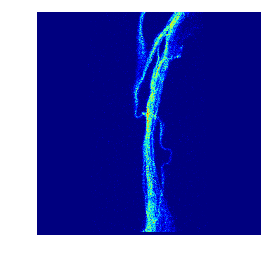

<function __main__.show_image>

In [52]:
def show_image(layer, image):
    show.display_2d_image(image[layer, :, :])
    
def show_side_by_side(layer, image1, image2):
    show.display_2d_images(image1[layer, :, :], image2[layer, :, :], image1_title='Fixed', image2_title='Moving')
    
data.set_active_image(1, 0, 100, "registered")
interact(show_image, layer=(0, data.get_image_size()[0]-1, 1), image=fixed(data[:]))

In [115]:
import numpy
import scipy.linalg as linalg
from math import sqrt, asin
data.set_active_image(2, 0, 100, "registered")
transform = data.get_transform()
sitk.Show(data.get_itk_image())
array = numpy.array(transform.GetMatrix()).reshape(3,3)

rotation = linalg.polar(array, "right")[0]
print linalg.det(rotation)

matrix = tuple(rotation.ravel())



1.0


In [117]:
data.set_active_image(0, 0, 50, "original")
sitk.Show(data.get_itk_image())


In [116]:
data.set_active_image(0, 0, 100, "psf")
image = data.get_itk_image()
ref = data[:]

#data.set_active_image(1, 0, 100, "registered")
#transform = data.get_transform()

transform = sitk.AffineTransform(3)
transform.SetMatrix(matrix)
transform.SetTranslation((0.0, 0.0, 0.0))

imdims = image.GetSize()
imspacing = image.GetSpacing()

print imdims
print imspacing

center = map(
    lambda size, spacing: spacing * size / 2, imdims, imspacing
)

print center

transform.SetFixedParameters(center)

result = sitk.Show(itkutils.resample_image(image, transform))

#interact(show_side_by_side, layer=(0, result.shape[0]-1, 1), image1=fixed(ref), image2=fixed(result))


(240, 240, 307)
(0.02217400074005127, 0.02217400074005127, 0.02217411994934082)
[2.6608800888061523, 2.6608800888061523, 3.403727412223816]


This should be exactly same as the first registered view, because the regular STED image is the reference image, and will not thus go through a spatial transformation. Let's test drive that.

Now. Let's start adding stuff to the data structure. First, let's add 60% downscaled versions of the two views.

Succesfully created the 60% downscaled views


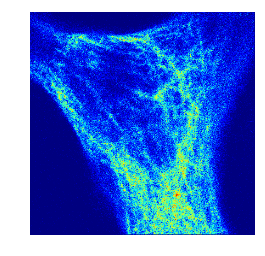

In [12]:
data.create_rescaled_images(40)

print "Succesfully created the 60% downscaled views"
data.set_active_image(0, 0, 40, "original")
show.display_2d_image(data[40, :, :])

Let's try to add a transform and then add the registered view.

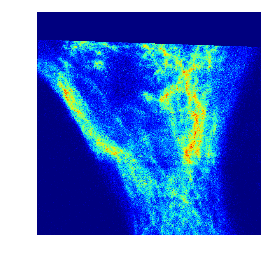

In [2]:
file_path = "/home/sami/Data/SuperTomo2/Import/transform_scale_100_index_1_channel_0_angle_40.txt"

data.set_active_image(0, 0, 100, "original")
reference = data.get_itk_image()

data.set_active_image(1, 0, 100, "original")
moving = data.get_itk_image()

transform = utils.read_itk_transform(file_path, return_itk=True)

registered = itkutils.resample_image(moving, transform, reference=reference)
registered, spacing = itkutils.convert_to_numpy(registered)

data.add_registered_image(registered, 100, 1, 0, spacing)
show.display_2d_image(registered[100, :, :])

Which should be the same as the registered image at index 1

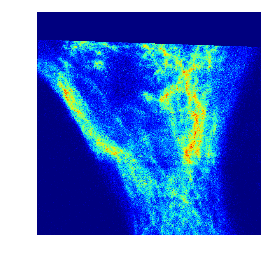

In [7]:
data.set_active_image(1, 0, 100, "registered")
show.display_2d_image(data[100, :, :])


In [4]:
transform_type, params, fixed_params = utils.read_itk_transform(file_path)

data.add_transform(100, 1, 0, params, fixed_params, transform_type)

data.set_active_image(1, 0, 100, "registered")
print data.get_transform()

itk::simple::Transform
 VersorRigid3DTransform (0x42b6900)
   RTTI typeinfo:   itk::VersorRigid3DTransform<double>
   Reference Count: 1
   Modified Time: 979
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999605 0.00984584 0.0263137 
     0.0132161 0.661707 -0.749646 
     -0.0247929 0.749698 0.661315 
   Offset: [-0.157292, 6.4404, -3.5539]
   Center: [12.4665, 11.4598, 2.44621]
   Translation: [0.0149872, 0.894592, 3.89992]
   Inverse: 
     0.999605 0.0132161 -0.0247929 
     0.00984584 0.661707 0.749698 
     0.0263137 -0.749646 0.661315 
   Singular: 0
   Versor: [ 0.411273, 0.0140186, 0.000924479, 0.911404 ]



Voila! That all for now.

In [3]:
print data.get_scales("original")

[100, 40]
